<a href="https://colab.research.google.com/github/Margauxxxxxxx/NLP_Project/blob/master/Projet_NLP_JEHLE_THOREZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning for NLP Project**

### Prediction of movies rating - Camille Jehle and Margaux Thorez


We are going to use a corpus containing stories of films from the IMDB to predict movies ratings. For that we are going to use the movies_metadata.csv database. We will use NLP tools to add the polarity of Amazon overviews as an explainatory variable. 

### **Summary of our project :**

---



I. Import of the different datasets (one with movies characteristics, one with written Amazon reviews and another one to merge the previous databases). We included also some descriptive statistics. 

II. Sentiment Analysis on already tagged film reviews. We train 2 different models (using Word2Vec and BERT) and compare them. We apply the best one to the Amazon reviews. 

III. New preprocessing to get a cleaned dataset for our predictions (includes removing some variable and convert some to dummies). Creation of a topic model on the overview of the movies. 

IV. Prediction of the ratings without the variables created with the sentiment analysis and the topic model. 

V. Prediction of the ratings with the variables created with the sentiment analysis and the topic model. 

VI. Comparison of the predictions and short conclusion

---

### **I - Data import and preliminary analysis**

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

#### **IMBD movies database**



In [0]:
!git clone <repo_url>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `git clone <repo_url>'


In [0]:
#Importation of the database
import requests, zipfile, io

r = requests.get('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/movies_metadata.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z = z.extractall()

In [0]:
df = pd.read_csv('movies_metadata.csv')
s = 'Movies database has {:,} rows and {:,} columns'
print(s.format(df.shape[0], df.shape[1]))
df.head(3)

Movies database has 45,466 rows and 24 columns


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


#### **Selection of IMBD movies with Amazon reviews**

We are going to work with the movies for which we have Amazon reviews. We select such movies using the Movies_and_TV_metadata database (desciption of the movies with Amazon reviews : http://deepyeti.uscd.edu/jianmo/amazon/index.html), and save the new database in a csv file in the GitHub of our project. 

In [0]:
#Importation of the database of the movies with Amazon reviews

r = requests.get('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/movies_Amazon.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z = z.extractall()

df_movies = pd.read_csv('movies_Amazon.csv')
s = 'The database of Amazon movies has {:,} rows and {:,} columns'
print(s.format(df_movies.shape[0], df_movies.shape[1]))
df_movies.head(3)

The database of Amazon movies has 16,777 rows and 15 columns


,category,title,rank,main_cat,asin,image,description,brand,also_buy,also_view,price,details,feature,date,tech1
0,"['Movies & TV', 'A&E Home Video', 'All A&E Tit...",The Avengers,"718,117inMoviesTV(",Movies & TV,0767015525,NaN,['The long-running Avengers series added some ...,NaN,"['B00005O7NC', 'B0000639DY', 'B00007GZYB', 'B0...","['B0083SBMBM', 'B00E5G03I4', 'B00005O7NC', 'B0...",NaN,NaN,NaN,NaN,NaN
1,"['Movies & TV', 'A&E Home Video', 'All A&E Tit...",Jane Eyre,"44,230inMoviesTV(",Movies & TV,0767020294,['https://images-na.ssl-images-amazon.com/imag...,"[""Samantha Morton, Ciaran Hinds. A young gover...",Samantha Morton,"['B0053Q9DHW', 'B000784WMW', 'B00005RHF8', 'B0...","['B000784WMW', 'B0053Q9DHW', 'B000MGBLHS', 'B0...",$9.09,NaN,NaN,NaN,NaN
2,"['Movies & TV', 'Studio Specials', 'Sony Pictu...",Absence of Malice,"159,100inMoviesTV(",Movies & TV,0767804325,['https://images-na.ssl-images-amazon.com/imag...,"[""In America, can a man be guilty until proven...",Bob Balaban,"['B00407PNX8', 'B007N31YH0', 'B000059HAN', 'B0...","['B00407PNX8', 'B000059HAN', 'B00AY587RY', 'B0...",$8.95,NaN,NaN,NaN,NaN


We are now going to select the movies that are in both databases.

In [0]:
#We look title by title to know which movies are present in both databases

ASIN_to_keep=[]
movies_to_keep=[]
for k in range(len(df_movies.title)):
    if df_movies.title[k] in list(df.title):
        ASIN_to_keep.append(df_movies.asin[k])
        movies_to_keep.append(df_movies.title[k])


In [0]:
df = df[df['title'].isin(movies_to_keep)]
s = 'The new movies_database has {:,} rows and {:,} columns'
print(s.format(df.shape[0], df.shape[1]))
df.head(3)

The new movies_database has 14,215 rows and 24 columns


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.9249,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
15,False,NaN,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,524,tt0112641,en,Casino,The life of the gambling paradise – Las Vegas ...,10.1374,/xo517ibXBDdYQY81j0WIG7BVcWq.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-11-22,116112375.0,178.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,No one stays at the top forever.,Casino,False,7.8,1343.0


We saved this database to be able then to downloaded it directly :

In [0]:
#Database of IMBD movies that have Amazon reviews
df = pd.read_csv('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/movies_IMBD.csv?raw=true')
s = 'Movies database has {:,} rows and {:,} columns'
print(s.format(df.shape[0], df.shape[1]))
df.head(3)

Movies database has 14,215 rows and 24 columns


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
2,False,NaN,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,524,tt0112641,en,Casino,The life of the gambling paradise – Las Vegas ...,10.137389,/xo517ibXBDdYQY81j0WIG7BVcWq.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-11-22,116112375.0,178.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,No one stays at the top forever.,Casino,False,7.8,1343.0


We only keep the movies that have more than 100 votes to remove the outliers that have just few votes and an average rating of 0. 

In [0]:
#We are going to work only with the movies that have more than 100 votes
df = df[df['vote_count']>100]
df.shape

(2646, 24)

#### **Descriptive Statistics of IMBD database**

You can find below some descriptive about our movie_database. We start by studying numeric variables.  

In [0]:
#For some variables, the not encoded as numeric variable
#For example, we transform popularity and budget to numeric
df.popularity = pd.to_numeric(df.popularity, errors='coerce')
df.budget = pd.to_numeric(df.budget, errors='coerce')

In [0]:
#Description of numeric variables
df.drop(['id'], axis=1).describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,2.646000e+03,2646.000000,2.646000e+03,2646.000000,2646.000000,2646.000000
mean,3.090131e+07,11.046657,9.355244e+07,107.587302,6.406311,847.160998
std,4.374776e+07,15.645015,1.798050e+08,21.996952,0.836476,1308.579388
min,0.000000e+00,0.239993,0.000000e+00,0.000000,3.100000,101.000000
25%,1.817500e+05,6.965891,2.617845e+05,94.000000,5.800000,176.000000
50%,1.500000e+07,9.268047,2.826032e+07,104.000000,6.400000,358.500000
75%,4.000000e+07,12.160227,1.016753e+08,117.000000,7.000000,894.500000
max,3.800000e+08,547.488298,2.068224e+09,550.000000,9.100000,12269.000000


In [0]:
#Description of the others variables
df.describe(include=[np.object])

,adult,belongs_to_collection,genres,homepage,id,imdb_id,original_language,original_title,overview,poster_path,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,video
count,2646,610,2646,1070,2646,2646,2646,2646,2646,2646,2646,2646,2646,2646,2646,2356,2646,2646
unique,1,424,804,1061,2644,2644,25,2551,2644,2644,2326,336,2111,368,2,2351,2532,1
top,False,"{'id': 645, 'name': 'James Bond Collection', '...","[{'id': 18, 'name': 'Drama'}]",http://www.kungfupanda.com/,265189,tt2121382,en,King Kong,"While holidaying in the French Alps, a Swedish...",/o3Im9nPLAgtlw1j2LtpMebAotSe.jpg,"[{'name': 'Universal Pictures', 'id': 33}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-07,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some things are better left top secret.,Beauty and the Beast,False
freq,2646,9,156,3,2,2,2357,3,2,2,30,1551,7,1684,2645,2,4,2646


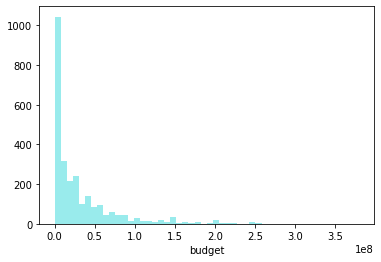

In [0]:
#Plot of "budget" variable
sns.distplot(df.budget, kde=False, color='darkturquoise')

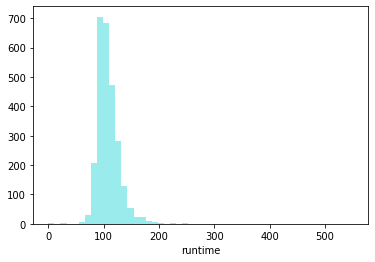

In [0]:
#Plot of "runtime" variable
sns.distplot(df.runtime, kde=False, color='darkturquoise')
#Most films last for 1h40

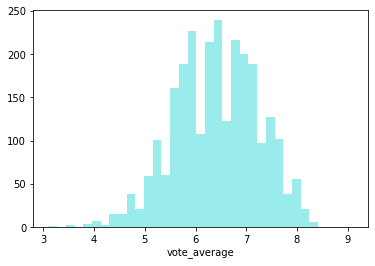

In [0]:
#Plot of "vote_average" variable
sns.distplot(df.vote_average, kde=False, color='darkturquoise')
#This is our variable of interest : we are trying to predict it using several explanatory variables

Regarding the movies description, more than 75% have no revenue. 

As some movies have no runtime, we might have to remove them. We can also see that some movies have a very high runtime, so we might see them as well as outliers... 

We finally can see that the most part of the average vote are between 5 and 6.8 (50%). Moreover, more than 75% of the movies have been ranked by less than 40 spectators. 

Now let's visualize the bivariate distribution and correlation of some variables with our variable of interest "vote_average" in a scatterplot.

In [0]:
from scipy.stats import pearsonr

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


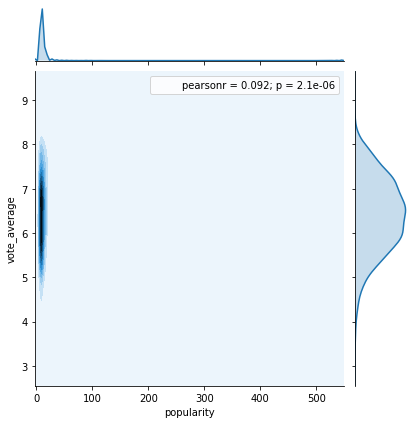

In [0]:
#Correlation between "vote_average" and "popularity"
sns.jointplot(x='popularity', y='vote_average', data=df, kind='kde').annotate(pearsonr)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


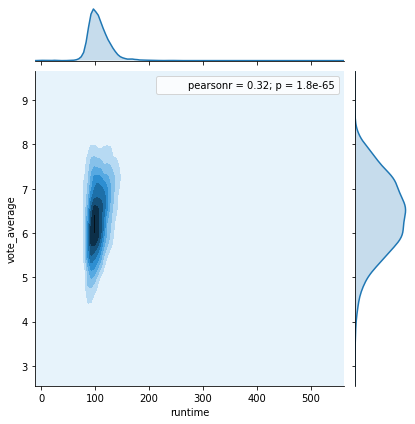

In [0]:
#Correlation between "vote_average" and "runtime"
sns.jointplot(x='runtime', y='vote_average', data=df, kind='kde').annotate(pearsonr)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


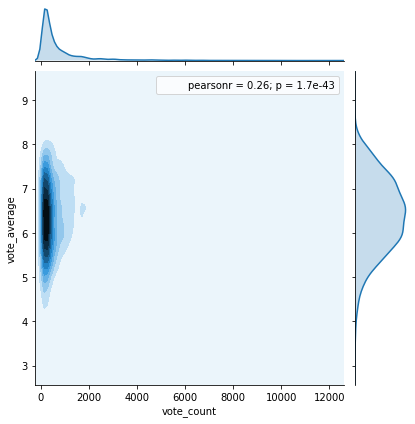

In [0]:
#Correlation between "vote_average" and "vote_count"
sns.jointplot(x='vote_count', y='vote_average', data=df, kind='kde').annotate(pearsonr)

The variables "runtime" and "vote_count" are the most correlated with "vote_average", but not that much.

In [0]:
#We count missing values per column in order to understand which variables we are going to use 
df.isnull().sum(axis=0)

adult                       0
belongs_to_collection    2036
budget                      0
genres                      0
homepage                 1576
id                          0
imdb_id                     0
original_language           0
original_title              0
overview                    0
popularity                  0
poster_path                 0
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline                   290
title                       0
video                       0
vote_average                0
vote_count                  0
dtype: int64

Now let's study the "genres" variable, which can be a good explainatory variable :


In [0]:
#Number of different genres (including combinasions)
print(len(df.genres.unique()))

804


We get a high number of "genres" as each movie can belongs to several "genres" (Drama and romance for example). We are going to fix this problem. 

In [0]:
#We are now going to separate the genres that are in a dictionnary applying literal_eval

from ast import literal_eval

df_genres = df.copy()
df_genres['genres'] = df_genres['genres'].fillna('[]')
df_genres['genres'] = df_genres['genres'].apply(literal_eval)
df_genres['genres'] = df_genres['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [0]:
#For the data analysis, we are going to create a new dataframe with one row per genre per movie (so a movie with more than one genre is going to appear more than one time)

g = df_genres.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
g.name = 'genre'
df_genre_solo = df_genres.drop('genres', axis=1).join(g)

df_genre_solo.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Family
1,False,NaN,60000000,NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,Action
1,False,NaN,60000000,NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,Crime


In [0]:
#Number of different genres
print(len(df_genre_solo.genre.unique()))

20


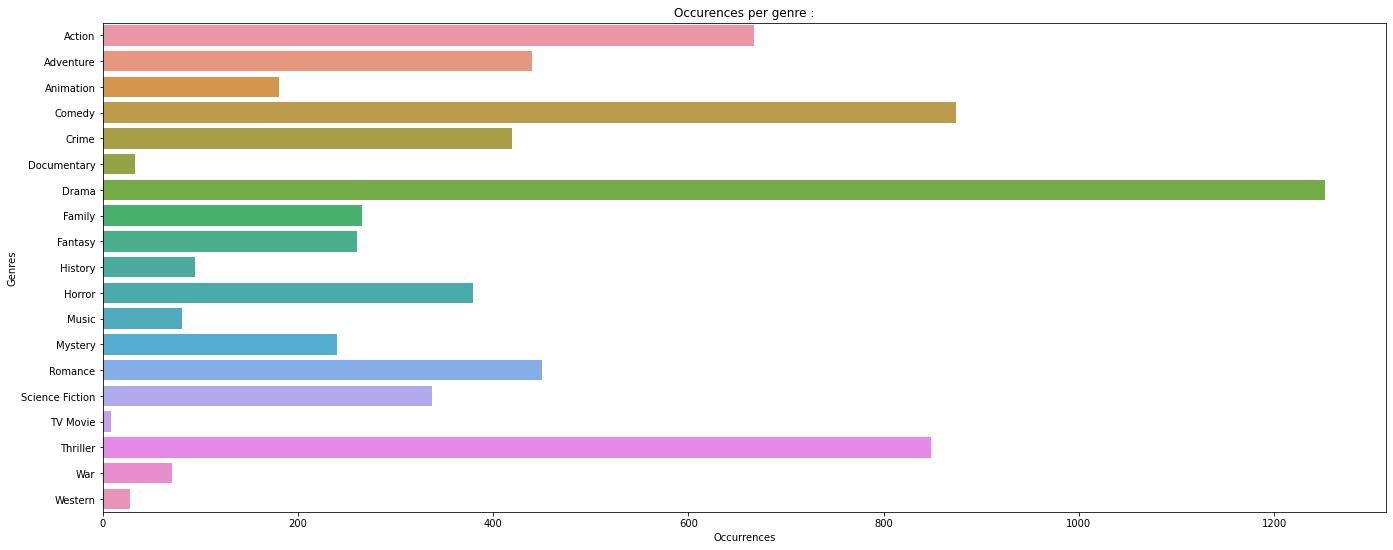

In [0]:
#We plot the occurences per genres in order to see which are the most represented
genre_count = df_genre_solo['genre'].value_counts().sort_index()
df_genre_count = pd.DataFrame({'genre': genre_count.index, 'count': genre_count.values})
f, ax = plt.subplots(figsize=(23, 9))
sns.barplot(x = 'count', y = 'genre', data=df_genre_count)
ax.set_title('Occurences per genre :')
ax.set_xlabel('Occurrences')
ax.set_ylabel('Genres')
plt.show()

We can see that some genres are more represented that other ones. 

We can also study the original language : 

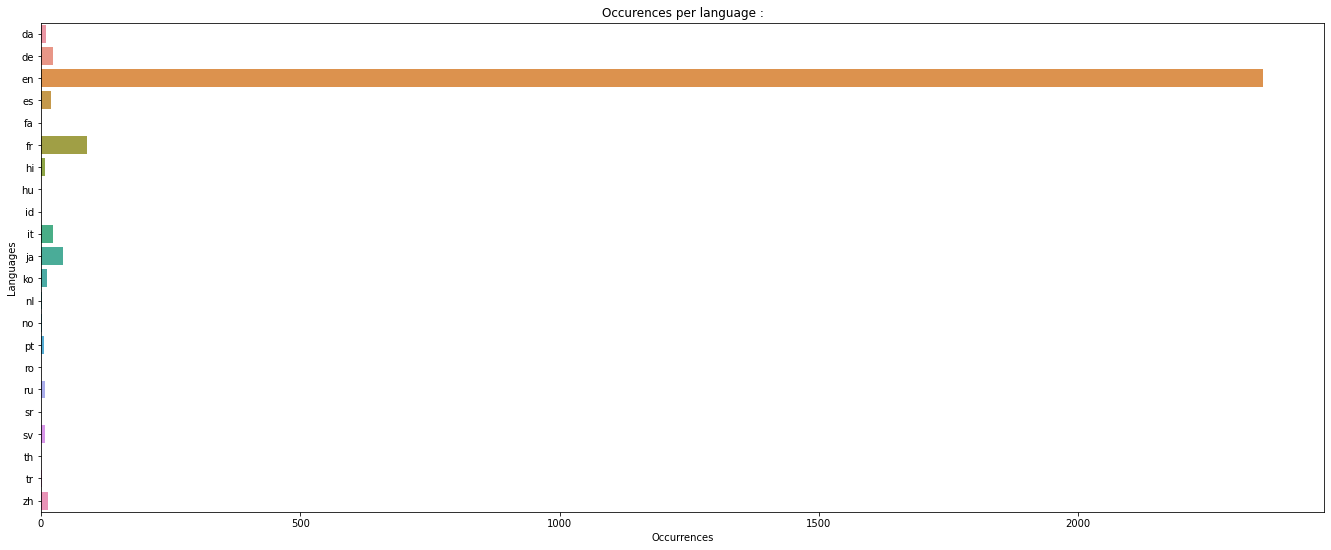

In [0]:
language_count = df['original_language'].value_counts().sort_index()
df_language_count = pd.DataFrame({'language': language_count.index[3:], 'count': language_count.values[3:]})
f, ax = plt.subplots(figsize=(23, 9))
sns.barplot(x = 'count', y = 'language', data=df_language_count)
ax.set_title('Occurences per language :')
ax.set_xlabel('Occurrences')
ax.set_ylabel('Languages')
plt.show()

As expected, most movies are english films. There is still a significant number of french movies. And therefore in order to have consistent classes of original languages, we will just use the 2 most represented languages : english and french.

Now let's visualize the length of the "overview" variable : 

Mean Length of overviews : 295.10249621785175


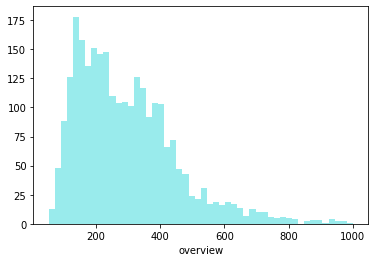

In [0]:
# Length of overviews in characters
df.overview =df.overview.apply(str) 
print("Mean Length of overviews :", df.overview.drop_duplicates().apply(len).mean())
#Distribution of overview's lenght
sns.distplot(df.overview.drop_duplicates().apply(len), bins=50, kde=False, color='darkturquoise')

The mean length of the overviews is of 295 characters, which is not that much. That is why we are going to use Amazon reviews for Sentiment Analysis. 

#### **Import of the Amazon reviews**

We use the Amazon review data for Movies and TV (3 millions of written movie reviews : http://deepyeti.uscd.edu/jianmo/amazon/index.html). 

As this database is huge, we focus on the reviews of the IMBD movies with more than 100 votes. This correspond to about 90 000 reviews for 800 different films. 
This database have been saved in a csv file that we can download from the GitHub of our project. 

In [0]:
#Importation of the database of the movies with Amazon reviews

r = requests.get('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/Amazon_reviews_IMBD.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z = z.extractall()

df_amazon = pd.read_csv('Amazon_reviews_IMBD.csv', engine='python')
df_amazon.rename(columns = {'reviewText':'comment'}, inplace = True)
df_amazon['label']=[0]*df_amazon.shape[0] #To be determined by NLP

s = 'The database has {:,} rows and {:,} columns'
print(s.format(df_amazon.shape[0], df_amazon.shape[1]))
df_amazon.head(5)

The database has 90,855 rows and 5 columns


,overall,asin,comment,title,label
0,5.0,0005089549,So sorry I didn't purchase this years ago when...,I.Q.,0
1,5.0,0005089549,Believe me when I tell you that you will recei...,I.Q.,0
2,2.0,0005089549,NOt a great tape but the quality is good and f...,I.Q.,0
3,5.0,0005089549,It met all of my expectations. I was well sat...,I.Q.,0
4,5.0,000503860X,"I have seen X live many times, both in the ear...",Junior,0


Descriptive statistics of the Amazon reviews database :

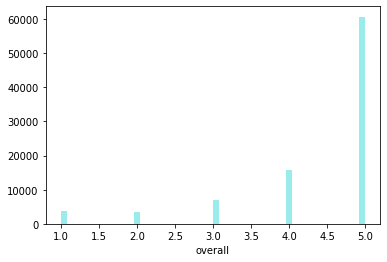

In [0]:
#Plot of the "overall" variable of the Amazon reviews database
#Overall correspond to note given by the client to the product
sns.distplot(df_amazon.overall, kde=False, color='darkturquoise')

As explained in our report, we use another base to train our NLP models. This database contains 50 000 written film reviews already tagged. 

We download from GitHub the data that we use to train and choose the best Sentiment Analysis model. Large Movie Review Dataset (https://ai.stanford.edu/~amaas/data/sentiment/): 50000 written movie reviews labelled (positive/negative)

In [0]:
#Data use to train and choose the model
#Data already tagged
#50 000 film overviews
df1=pd.read_csv('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/test_neg.csv?raw=true',engine='python')
df2=pd.read_csv('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/test_pos.csv?raw=true',engine='python')
df3=pd.read_csv('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/train_neg.csv?raw=true',engine='python')
df4=pd.read_csv('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/train_pos.csv?raw=true',engine='python')

df_tagged=pd.concat([df1,df4,df3,df2],axis=0)
df_tagged['label']=12500*[0]+12500*[1]+12500*[0]+12500*[1]
df_tagged.reset_index(drop=True, inplace=True)
df_tagged.head()

,comment,id,label
0,Once again Mr. Costner has dragged out a movie...,tt0406816,0
1,This is a pale imitation of 'Officer and a Gen...,tt0406816,0
2,"It seems ever since 1982, about every two or t...",tt0406816,0
3,"Wow, another Kevin Costner hero movie. Postman...",tt0406816,0
4,"Alas, another Costner movie that was an hour t...",tt0406816,0


### **II - Sentiment Analysis : predicting the polarity of Amazon reviews**

We are using two different approaches : one using Word2Vec as a word embedding technique and a second one using the pretrained model of BERT. 

In [0]:
#Model are trained on tagged movie overviews
#Split train/validation/test sets
#We use 35 000 reviews to train our models, 7500 to evaluate them and another 7500 to choose the best model. 
train_set,val_set= train_test_split(df_tagged,test_size=0.3, random_state=42)
test_set,val_set= train_test_split(val_set,test_size=0.5, random_state=42)
train_set.reset_index(inplace=True)
val_set.reset_index(inplace=True)
test_set.reset_index(inplace=True)

#####**Word2Vec Approach**

We use Word2Vec as an embedding technique and then use machine learning on the vectors created to predict the polarity of the reviews

Data preprocessing :

We start the data preprocessing by cleaning the text. Our cleaning functions include a function to lowercase, one remove the html characters, one remove frequent stop words (of, the...) and finally another to remove special characters like "". 

In [0]:
#Cleaning functions
import html
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

def lowercase(tokens):
    tokens = list(map(lambda x: x.lower(), tokens))
    return ''.join(list(tokens))

def remove_html(tokens):
    return html.unescape(tokens)

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english')) 
    tokens = word_tokenize(tokens) 
    filtered_sentence = [w for w in tokens if not w in stop_words] 
    return ' '.join(filtered_sentence)

special=r"\&\#[0-9]+\;''``"
def remove_special_characters(tokens):
    tokens = word_tokenize(tokens) 
    filtered_sentence = [w for w in tokens if not w in special] 
    return ' '.join(filtered_sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#Example
example=lowercase(df_tagged.comment[12342])
example=remove_html(example)
example=remove_stop_words(example)
example=remove_special_characters(example)
print('TEXTE ORIGINAL :',df_tagged.comment[12342],'\n')
print('TEXTE NETTOYE :',example)

TEXTE ORIGINAL : This is the worst movie I have ever seen in my entire life. Unless you're into masochism, never see it. It was an insufferably long, pointless, eye-harming, depressing movie and will forever top my list of bad movies. Whoever wrote this movie is a sadist. I almost cried at the end, that's how bad it was. I'd like to give it zero stars, but since that's not an option, I give it one. 

TEXTE NETTOYE : worst movie ever seen entire life . unless 're masochism , never see . insufferably long , pointless , eye-harming , depressing movie forever top list bad movies . whoever wrote movie sadist . almost cried end , 's bad . 'd like give zero stars , since 's option , give one .


We now lemmatize and tokenize the text. 

In [0]:
#Lemmatizing and tokenizing

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

punctuations="?:!.,;"

#To lemmatize word per word
#We first have to determine the function of each words (using POS) to get the best lemmatization
def word_lemmatize(tagged):
    #print(tagged)
    pos=tagged[1][0]
    word=tagged[0]
    #print(pos)
    if pos=='J':
        return(wordnet_lemmatizer.lemmatize(word, pos="a"))
    elif pos=='V':
        return(wordnet_lemmatizer.lemmatize(word, pos="v"))
    elif pos=='N':
        return(wordnet_lemmatizer.lemmatize(word, pos="n"))
    elif pos=='R':
        return(wordnet_lemmatizer.lemmatize(word, pos="r"))
    else:          
        return(word)

#To lemmatize and tokenize the overview
def lemmatize_tokenize(tokens):
    sentence=[]
    sentence_words = word_tokenize(tokens)
    tagged=pos_tag(sentence_words)
    for k in range(len(sentence_words)):
        tag=tagged[k]
        if (tag[0] in punctuations)==False:
            #To remove punctuations
            sentence.append(word_lemmatize(tag))
    return sentence

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
example_preprocessed=lemmatize_tokenize(example)
print('TEXTE FINAL:',example_preprocessed)

TEXTE FINAL: ['bad', 'movie', 'ever', 'see', 'entire', 'life', 'unless', "'re", 'masochism', 'never', 'see', 'insufferably', 'long', 'pointless', 'eye-harming', 'depressing', 'movie', 'forever', 'top', 'list', 'bad', 'movie', 'whoever', 'write', 'movie', 'sadist', 'almost', 'cried', 'end', "'s", 'bad', "'d", 'like', 'give', 'zero', 'star', 'since', "'s", 'option', 'give', 'one']


 Let's apply this functions to the data. 

In [0]:
train_set["preprocessed"]=train_set.comment.apply(lambda row: lowercase(row)).apply(lambda row: remove_html(row)).apply(lambda row: remove_stop_words(row)).apply(lambda row: remove_special_characters(row))
val_set["preprocessed"]=val_set.comment.apply(lambda row: lowercase(row)).apply(lambda row: remove_html(row)).apply(lambda row: remove_stop_words(row)).apply(lambda row: remove_special_characters(row))
test_set["preprocessed"]=test_set.comment.apply(lambda row: lowercase(row)).apply(lambda row: remove_html(row)).apply(lambda row: remove_stop_words(row)).apply(lambda row: remove_special_characters(row))

In [0]:
#It takes some time
train_set["preprocessed"]=train_set.preprocessed.apply(lambda row: lemmatize_tokenize(row))
val_set["preprocessed"]=val_set.preprocessed.apply(lambda row: lemmatize_tokenize(row))
test_set["preprocessed"]=test_set.preprocessed.apply(lambda row: lemmatize_tokenize(row))

In [0]:
train_set.head()

,index,comment,id,label,preprocessed
0,38094,A bunch of full-length movies featuring the Mu...,tt0079588,1,"[bunch, full-length, movie, feature, muppets, ..."
1,40624,This film has to be as near to perfect a film ...,tt0043117,1,"[film, near, perfect, film, john, ford, make, ..."
2,49425,"Quick summary of the book: Boy, Billy Tepper, ...",tt0103112,1,"[quick, summary, book, boy, billy, tepper, 12,..."
3,35734,I have yet to read a negative professional rev...,tt0445161,0,"[yet, read, negative, professional, review, mo..."
4,41708,The young John Garfield turned in a fine perfo...,tt0032022,1,"[young, john, garfield, turn, fine, performanc..."


Now we are going to use word2vec.

In [0]:
#Words embedding with Word2vec
from gensim.models import Word2Vec
from multiprocessing import cpu_count
cpu = cpu_count()

#The vocabulary is constructed using only the train_set
model_vw = Word2Vec(size=100, window=5, min_count=3, workers=cpu)
model_vw.build_vocab(train_set.preprocessed)

In [0]:
#To transform the results of word2vec into vectors
def vector_construction(text, size,model):
    vec = np.zeros(size).reshape((1, size))
    nb = 0
    for word in text:
        try:
            vec=vec+model[word].reshape((1, size))
            nb=nb+1.
        except KeyError:
            continue
    if nb != 0:
        vec=vec/nb
    return vec

In [0]:
#Training on train_set
print("Training the W2V ...")
model_vw.train(train_set.preprocessed, total_examples=len(train_set.preprocessed), epochs=2)
train_array = np.concatenate([vector_construction(z, 100,model_vw) for z in train_set.preprocessed])

In [0]:
model_vw.most_similar('awful')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('horrible', 0.9326626062393188),
 ('terrible', 0.914169192314148),
 ('dreadful', 0.8500727415084839),
 ('atrocious', 0.827540397644043),
 ('bad', 0.8036673069000244),
 ('pathetic', 0.7990529537200928),
 ('lousy', 0.7928122878074646),
 ('suck', 0.7920595407485962),
 ('lame', 0.781204342842102),
 ('horrendous', 0.7673866748809814)]

In [0]:
#Training on val_set
print("Training the W2V ...")
model_vw.train(val_set.preprocessed, total_examples=len(val_set.preprocessed), epochs=2)
val_array = np.concatenate([vector_construction(z, 100,model_vw) for z in val_set.preprocessed])

Training the W2V ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


As we get transformed our sentences into vectors, we can now use machine learning techniques to predict the polarity of the overview. We are going to use XGBoost.

In [0]:
X_train= pd.DataFrame(train_array)
y_train= train_set["label"]

X_val= pd.DataFrame(val_array)
y_val= val_set["label"]

In [0]:
#XGBoost 
import xgboost as xgb
train=xgb.DMatrix(X_train, label=y_train)
test=xgb.DMatrix(X_val, label=y_val)
xgb_reg = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)
xgb = xgb_reg.fit(X_train, y_train)
#Predictions
y_pred_boost=xgb.predict(X_val)

In [0]:
#To evaluate the accuracy of our predictions
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

def metrics(y_true,y_pred):

  #Accuracy
  accuracy=accuracy_score(y_true, y_pred)
  print("Baseline Accuracy: ",round(accuracy*100),"%")

  #Classification report
  print('')
  print('Classification report')
  print(classification_report(y_true,y_pred,target_names=['positive','negative']))
    
  #Confusion matrix
  print('')
  print('Confusion matrix')
  cm=confusion_matrix(y_true,y_pred)
  labels = ['negative','positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 18},cmap='coolwarm', linewidth=0.5, fmt="")
  b, t = plt.ylim() 
  b += 0.5 
  t -= 0.5 
  plt.ylim(b, t) 
  plt.show()
    

def roc(y_true0,score_preds0,y_true1,score_preds1):
  #ROC curve : to compare two models (used after to compare our models)
  lr_fpr0, lr_tpr0, _ = roc_curve(y_true0,score_preds0)
  auc = roc_auc_score(y_true0,score_preds0)
  lr_fpr1, lr_tpr1, _ = roc_curve(y_true1,score_preds1)
  auc1 = roc_auc_score(y_true1,score_preds1)
  plt.plot(lr_fpr0,lr_tpr0, color='darkorange', label='ROC curve Word2Vec(area = %0.3f)' % auc)
  plt.plot(lr_fpr1, lr_tpr1, label='ROC curve BERT (area = %0.3f)' % auc1)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

We evaluate the results using XGBoost :

Baseline Accuracy:  79.0 %

Classification report
              precision    recall  f1-score   support

    positive       0.79      0.80      0.80      3804
    negative       0.79      0.78      0.79      3696

    accuracy                           0.79      7500
   macro avg       0.79      0.79      0.79      7500
weighted avg       0.79      0.79      0.79      7500


Confusion matrix


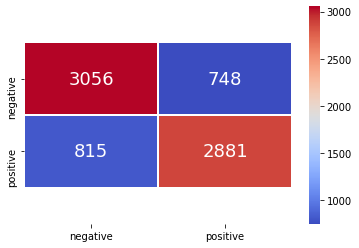

In [0]:
#Results using XGBoost
metrics(y_val,y_pred_boost)

We get an accuracy of about 80% and we can see our model predicts negative overview better than positive. 

Word2vec hyperparameters : we want to choose the best vocabulary size to improve the accuracy of our model. We test sizes between 50 and 250. 

In [0]:
import time
def duration(start_time, end_time):
    length = end_time - start_time
    mins = int(length / 60)
    secs = int(length - (mins * 60))
    return mins, secs

In [0]:
#Attention, quite long to run. 
size=np.arange(50,300,50)
accuracy_train=[]
accuracy_val=[]

for k in size:
  start_time = time.time()
  print('We are at step: ',k)
  wv= Word2Vec(size=k, window=5, min_count=3, workers=cpu)
  wv.build_vocab(train_set.preprocessed)
  wv.train(train_set.preprocessed, total_examples=len(train_set.preprocessed), epochs=5)
  train_array = np.concatenate([vector_construction(z,k,wv) for z in train_set.preprocessed])
  wv.train(val_set.preprocessed, total_examples=len(val_set.preprocessed), epochs=5)
  val_array = np.concatenate([vector_construction(z, k,wv) for z in val_set.preprocessed])
  X_train= pd.DataFrame(train_array)
  y_train= train_set["label"]

  X_val= pd.DataFrame(val_array)
  y_val= val_set["label"]

  import xgboost as xgb
  train=xgb.DMatrix(X_train, label=y_train)
  test=xgb.DMatrix(X_val, label=y_val)
  xgb_reg = xgb.XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.1, subsample=0.5)
  xgb_test= xgb_reg.fit(X_train, y_train)

  y_pred_val=xgb_test.predict(X_val)
  y_pred_train=xgb_test.predict(X_train)

  accuracy_train.append(accuracy_score(y_train, y_pred_train))
  accuracy_val.append(accuracy_score(y_val, y_pred_val))
  end_time = time.time()
  epoch_mins, epoch_secs = duration(start_time, end_time)
  print('Duration: ',epoch_mins,'m', epoch_secs,'s')
  print('')

We are at step:  50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Duration:  2 m 33 s

We are at step:  100
Duration:  3 m 35 s

We are at step:  150
Duration:  4 m 46 s

We are at step:  200
Duration:  5 m 45 s

We are at step:  250
Duration:  6 m 52 s



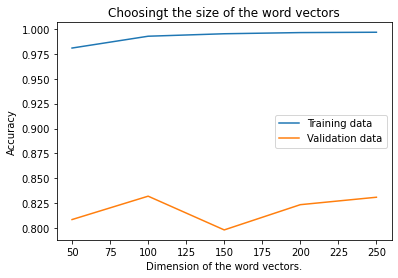

In [0]:
plt.plot(size,accuracy_train,label='Training data')
plt.plot(size,accuracy_val,label='Validation data')
plt.xlabel('Dimension of the word vectors.')
plt.ylabel('Accuracy')
plt.title('Choosingt the size of the word vectors')
plt.legend()
plt.show()

So we choose 100 as dimension. 

In [0]:
#Final Word2Vec model
model_vw = Word2Vec(size=100, window=5, min_count=3, workers=cpu)
model_vw.build_vocab(train_set.preprocessed)

#####**Using BERT for classification**

We now use BERT to train another classifier. 

Data Preprocessing :

In [0]:
!pip install transformers

In [0]:
#We use the data preprocesssing seen in class 
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler

class SSTDataset(Dataset):

    def __init__(self,df, maxlen, model_name='bert-base-uncased'):

        #Keep only the necessary columns
        self.df = df[['comment','label']]

        #Initialize the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'comment']
        label = self.df.loc[index, 'label']

        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        if self.tokenizer.cls_token is None:
          bos_token = self.tokenizer.bos_token
        else:
          bos_token = self.tokenizer.cls_token
          
        if self.tokenizer.sep_token is None:
          eos_token = self.tokenizer.eos_token
        else:
          eos_token = self.tokenizer.sep_token
        
        tokens = [bos_token] + tokens + [eos_token] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + [self.tokenizer.pad_token for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + [eos_token] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

The length maximum is fixed as high as possible (the gap in average accuracy between maxlen=128 and maxlen=256 is around 2%). 

In [0]:
#Creating training, validation and test dataloaders
train = SSTDataset(df=train_set, maxlen = 256, model_name='bert-base-uncased')
val = SSTDataset(df=val_set, maxlen = 256, model_name='bert-base-uncased')
test= SSTDataset(df=test_set, maxlen = 256, model_name='bert-base-uncased')


train_loader = DataLoader(train, batch_size =16,sampler = RandomSampler(train_set),num_workers=5)
val_loader = DataLoader(val, batch_size =16,sampler = RandomSampler(val_set),num_workers=5)
test_loader = DataLoader(test, batch_size =16,sampler = RandomSampler(test_set),num_workers=5)

Model definition : we are using the classifier based on BERT of the library Transformer

For the parameters  (the learning rate for example), we follow the recommandation of the original article introducing BERT : https://arxiv.org/pdf/1810.04805.pdf



In [0]:
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig

# BertForSequenceClassification : pretrained BERT model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)

#To use GPU
model.cuda()
device = torch.device("cuda")
print('We will use the GPU:', torch.cuda.get_device_name(0))

#Optimizer
# Default learning rate: 5e-5
optimizer = AdamW(model.parameters(),lr = 2e-5)


We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
from transformers import get_linear_schedule_with_warmup
#To update the learning rate 
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = len(train_set))


Model training

In [0]:
# Function to calculate the accuracy of our predictions 
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


This is our main function where we train and then evaluate our BERT classifier. 

In [0]:
def train_evaluate(model,optimizer,train_loader,val_loader):

  #####
  #Training part
  #####
  print('Training...')

  model.train()
  
  train_loss = 0
  train_accuracy = 0

  for step, (seq, attn_masks, labels) in enumerate(train_loader):

      # Report progress
      if step % 400 == 0 :
        print(int(100*step/len(train_loader)),'% finished')

      #To cuda
      seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
      
      model.zero_grad()        

      loss, logits = model(seq,attention_mask=attn_masks,labels=labels)

      #Loss
      train_loss += loss.item()

      #Accuracy
      logits = logits.detach().cpu().numpy()
      label = labels.to('cpu').numpy()
      train_accuracy += accuracy(logits, label)
        
      # Backward pass 
      loss.backward()

      
      #To prevent explosion of gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      #Optimization step
      optimizer.step()

      # Update the learning rate.
      scheduler.step()

  #Calculate the average loss and accuracy
  avg_train_loss = train_loss / len(train_loader)  
  avg_train_accuracy = train_accuracy / len(train_loader)          
    
  print("Training finished")
  print("  Average training loss: {0:.3f}".format(avg_train_loss))
  print("  Average training accuracy: {0:.3f}".format(avg_train_accuracy))

  #####
  #Validation part
  #####
  print("")
  print("Validation...")

  model.eval()

  eval_accuracy = 0
  eval_loss = 0
  #eval_steps = 0

  for (seq, attn_masks, labels) in val_loader:

    #To cuda
    seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

    with torch.no_grad():      
      loss, logits = model(seq, attention_mask=attn_masks,labels=labels)
            
      #Loss.
      eval_loss += loss.item()

      #Accuracy
      logits = logits.detach().cpu().numpy()
      label = labels.to('cpu').numpy()
      eval_accuracy += accuracy(logits,label)
        

  #Average accuracy over the validation set
  avg_val_accuracy = eval_accuracy / len(val_loader)
    
  #Average loss over the validation set
  avg_val_loss = eval_loss / len(val_loader)
    
  print("") 
  print("Validation finished")  
  print("  Average validation loss: {0:.3f}".format(avg_val_loss))
  print("  Average validation accuracy: {0:.3f}".format(avg_val_accuracy))

  return avg_train_loss,avg_train_accuracy,avg_val_loss,avg_val_accuracy

The number of epochs recommanded for classification is between 2 and 4.

In [0]:
#Attention, take some time 
#Duration dependent of the GPU proposed by Google Colab
N_EPOCHS = 4
loss_min = float('inf')
for epoch in range(N_EPOCHS):
  print('')
  print('======== Epoch {:} / {:} ========'.format(epoch+ 1, N_EPOCHS)) 
  start_time = time.time()
    
  avg_train_loss,avg_train_accuracy,avg_eval_loss,avg_eval_accuracy = train_evaluate(model,optimizer,train_loader,val_loader)
       
  end_time = time.time()
  epoch_mins, epoch_secs = duration(start_time, end_time)
  print('')
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')

  if avg_eval_loss < loss_min:
        loss_min = avg_eval_loss
        torch.save(model.state_dict(), 'best_model.pt')



======== Epoch 1 / 4 ========
Training...
0 % finished
18 % finished
36 % finished
54 % finished
73 % finished
91 % finished
Training finished
  Average training loss: 0.264
  Average training accuracy: 0.896

Validation...

Validation finished
  Average validation loss: 0.226
  Average validation accuracy: 0.915

Epoch: 01 | Epoch Time: 15m 51s

======== Epoch 2 / 4 ========
Training...
0 % finished
18 % finished
36 % finished
54 % finished
73 % finished
91 % finished
Training finished
  Average training loss: 0.160
  Average training accuracy: 0.951

Validation...

Validation finished
  Average validation loss: 0.272
  Average validation accuracy: 0.919

Epoch: 02 | Epoch Time: 15m 49s

======== Epoch 3 / 4 ========
Training...
0 % finished
18 % finished
36 % finished
54 % finished
73 % finished
91 % finished
Training finished
  Average training loss: 0.100
  Average training accuracy: 0.975

Validation...

Validation finished
  Average validation loss: 0.395
  Average validation ac

#####**Models evaluation : BERT or Word2Vec ?**

Results for BERT :
Baseline Accuracy:  93.0 %

Classification report
              precision    recall  f1-score   support

    positive       0.93      0.92      0.93      3753
    negative       0.92      0.94      0.93      3747

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500


Confusion matrix


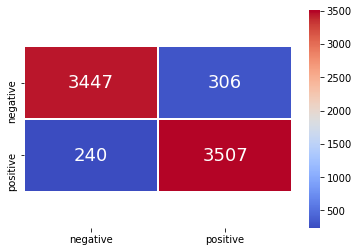


Duration:  1 m 0 s


In [0]:
#####
#BERT
#####
print('Results for BERT :')
start_time = time.time()
model.load_state_dict(torch.load('best_model.pt'))  
model.eval()

y_pred=[]
y_true=[]
scores=[]

for (seq, attn_masks, labels) in test_loader:
  #To cuda
  seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

  with torch.no_grad():      
    loss, logits = model(seq, attention_mask=attn_masks,labels=labels)
 
    #Prediction
    logits = logits.detach().cpu().numpy()
    label = labels.to('cpu').numpy()
    y_pred=y_pred+(list(np.argmax(logits, axis=1).flatten()))
    y_true=y_true+(list(label))
    scores=scores+(list(logits[:,1]))

metrics(y_true,y_pred)

end_time = time.time()
epoch_mins, epoch_secs = duration(start_time, end_time)
print('')
print('Duration: ',epoch_mins,'m', epoch_secs,'s')

Results for Word2Vec :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Baseline Accuracy:  81.0 %

Classification report
              precision    recall  f1-score   support

    positive       0.85      0.75      0.80      3753
    negative       0.77      0.87      0.82      3747

    accuracy                           0.81      7500
   macro avg       0.81      0.81      0.81      7500
weighted avg       0.81      0.81      0.81      7500


Confusion matrix


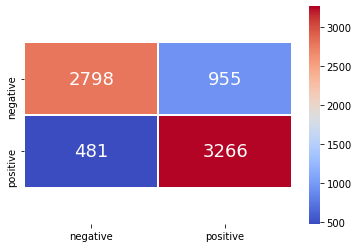


Duration:  0 m 9 s


In [0]:
#########
#Word2Vec
#########
print('Results for Word2Vec :')
start_time = time.time()

model_vw.train(test_set.preprocessed, total_examples=len(test_set.preprocessed), epochs=4)
test_array = np.concatenate([vector_construction(z, 100,model_vw) for z in test_set.preprocessed])
y_pred_test=xgb.predict(pd.DataFrame(test_array))
scores_x=xgb.predict_proba(pd.DataFrame(test_array))
metrics(test_set["label"],y_pred_test)

end_time = time.time()
epoch_mins, epoch_secs = duration(start_time, end_time)
print('')
print('Duration: ',epoch_mins,'m', epoch_secs,'s')

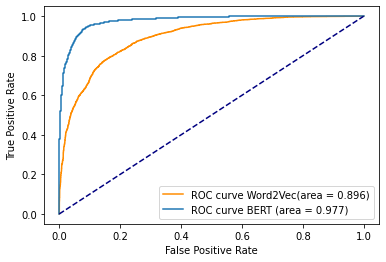

In [0]:
roc(test_set["label"],scores_x[:,1],y_true,scores)

The model BERT is clearly more accurate and outperforms the simple model using Word2Vec. We therefore use BERT to predict the polarity of the overviews of Amazon. 

#####**Inference on Amazon review : using BERT for classification**

In [0]:
#We load the best model
model.load_state_dict(torch.load('best_model.pt'))
def predict_polarity(model,df):
  sentiment=[]
  data=SSTDataset(df=df,maxlen=256)
  loader = DataLoader(data, batch_size =16,num_workers=5)
  model.eval()
  for step, (seq, attn_masks,labels) in enumerate(loader):

    # Report progress
    if step % 1000 == 0 :
      print(int(100*step/len(loader)),'% finished')

    #To cuda
    seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

    with torch.no_grad():      
      output = model(seq, attention_mask=attn_masks)
      logits=output[0]
      preds=logits.to('cpu').numpy()
      preds=np.argmax(preds, axis=1).flatten()
    sentiment=sentiment+list(preds)

  return sentiment

In [0]:
df_amazon['label']=predict_polarity(model,df_amazon)

0 % finished
17 % finished
35 % finished
52 % finished
70 % finished
88 % finished


Some descriptive statistics on our predictions

In [0]:
print('Positive reviews: ', round(sum(df_amazon.label)/df_amazon.shape[0]*100), '%')

Positive reviews:  85 %


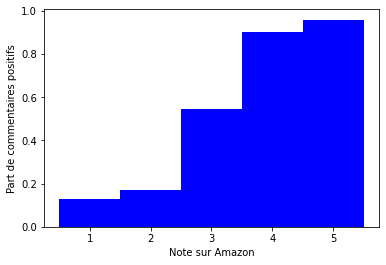

In [0]:
#Link between the overall note and the predicted polarity
part_positif=df_amazon[['overall','label']].groupby(['overall']).mean()
x=[1,2,3,4,5]
height = list(part_positif.label)
width = 1.0
plt.bar(x, height, width, color='blue')
plt.xlabel('Note sur Amazon')
plt.ylabel('Part de commentaires positifs')
plt.show()
#92% of the overview with a rating for the product of 5 are positive

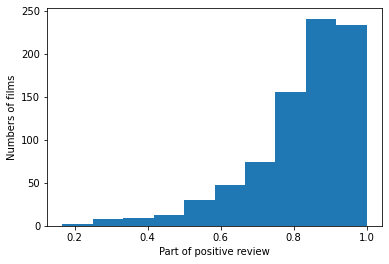

In [0]:
part_positif=df_amazon[['asin','label']].groupby(['asin']).mean()
part_positif=list(part_positif.label)
plt.hist(part_positif)
plt.xlabel('Part of positive review')
plt.ylabel('Numbers of films')
plt.show()
#More than 200 films have between 80 and 90% of positive review

### **III - Data preprocessing and topic model for the overview**

####**Creation of the IMBD working database**

As the process is very long, a csv file with the results of the Sentiment Analysis (which can be found in the GitHub of our project) was created.

In [0]:
r = requests.get('https://github.com/Margauxxxxxxx/NLP_Project/blob/master/amazon_data_with_polarity.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z = z.extractall()

df_polarity = pd.read_csv('amazon_data_with_polarity.csv', engine='python')
df_polarity.head()

,overall,asin,comment,title,label
0,5.0,0005089549,So sorry I didn't purchase this years ago when...,I.Q.,1
1,5.0,0005089549,Believe me when I tell you that you will recei...,I.Q.,1
2,2.0,0005089549,NOt a great tape but the quality is good and f...,I.Q.,1
3,5.0,0005089549,It met all of my expectations. I was well sat...,I.Q.,1
4,5.0,000503860X,"I have seen X live many times, both in the ear...",Junior,1


We create a new variable with the mean of the labels for each movie that is in the list, an also with the number of reviews in the database. This is the variables we are going to use to improve our prediction. 

In [0]:
#Mean of the labels
df_polarity_movie = df_polarity.groupby(['title'], as_index=False)[['label']].mean()
df_polarity_movie.rename(columns = {'label':'polarity'}, inplace = True)

#Nb of reviews
count=df_polarity.groupby(['title'], as_index=False)[['label']].count()
df_polarity_movie['nb_review']=list(count.label)
df_polarity_movie.head()

,title,polarity,nb_review
0,10 Years,1.000000,6
1,101 Dalmatians,0.875000,8
2,12 Rounds 2: Reloaded,1.000000,8
3,12 Years a Slave,0.428571,7
4,16 Wishes,0.200000,5


Now we add this new variables to our IMBD database. As we have no access to all the Amazon reviews database, the number of movies that have more than 100 votes and accessible reviews is 600. 

In [0]:
#Dropping movies duplicate values 
df.drop_duplicates(subset ="title", keep = False, inplace = True) 
df.reset_index(drop=True, inplace=True)

#We merge the movies database with the polarity one
df=pd.merge(df, df_polarity_movie, how = 'inner', on ='title')

s = 'Movies database has {:,} rows and {:,} columns'
print(s.format(df.shape[0], df.shape[1]))
df.head(3)

Movies database has 600 rows and 26 columns


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,polarity,nb_review
0,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,649,tt0061395,fr,Belle de jour,Beautiful young housewife Séverine Serizy cann...,10.142662,/rHvKWARrhNwSjbTMJrn5v4LtUJE.jpg,"[{'name': 'Paris Films Productions', 'id': 386...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1967-05-24,0.0,101.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,Luis Bunuel's Masterpiece of Erotica!,Belle de Jour,False,7.3,163.0,0.674419,43
1,False,"{'id': 9887, 'name': 'Species Collection', 'po...",35000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",NaN,9348,tt0114508,en,Species,"In 1993, the Search for Extra Terrestrial Inte...",13.492845,/94P6kzKH8aPmQmPr9yZjgy7BtQQ.jpg,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-07-07,113374103.0,108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Our time is up.,Species,False,5.5,457.0,0.867987,303
2,False,NaN,25000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,11777,tt0110099,en,I.Q.,Albert Einstein helps a young man who's in lov...,5.146351999999999,/kAYymfWcktoHSjQJEtfEIeByZR9.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1994-12-24,0.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Think Love.,I.Q.,False,5.9,112.0,1.000000,4


After the data analysis, we are going to drop some variables that does not seem to be very interesting for the prediction of the rating. Thus we are going to drop : "homepage", "imdb_id" (keeping "id" is enough), "poster_path", "status" and "video". We are not going to keep the variable "production_countries" and "spoken_languages" because they are correlated with the 'original_language' and/or give no more information. There are too many production companies so we are going to drop this column too. 

The variables variables "adult" and "belongs_to_collection" are transformed into dummies. 


In [0]:
df.drop(['homepage', 'imdb_id', 'poster_path', 'status','video','original_title','production_countries', 'spoken_languages','production_companies'], axis=1,inplace=True)
df['adult'] = pd.get_dummies(df['adult'])
df['belongs_to_collection'] = pd.isna(df['belongs_to_collection'])
df['belongs_to_collection'] = pd.get_dummies(df['belongs_to_collection'])

 We distinguish between films in english, french or other languages.

In [0]:
df['en']=1*(df.original_language=='en')
df['fr']=1*(df.original_language=='fr')
df.drop(['original_language'], axis=1,inplace=True)

We create two new dummies variables from 'release_date' : 'year' and 'month'. 

In [0]:
#Creation of new variables 'year' and 'month' instead of 'release-date'
df=df.dropna(subset=['release_date'])
df['release_date']=df['release_date'].astype(str)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce', format='%Y-%m-%d')
df['year'] = pd.DatetimeIndex(df['release_date']).year
df['month'] = pd.DatetimeIndex(df['release_date']).month
df = df.drop(['release_date'], axis=1)

#Turning them into dummies
df_month = pd.get_dummies(df['month'])
df = pd.concat([df, df_month], axis = 1)
df.drop(['month'], axis=1,inplace=True)
df.rename(columns={1.0: "january", 2.0: "february", 3.0: "march", 4.0: "april", 5.0: "may", 6.0: "june", 7.0: "july", 8.0: "august", 9.0: "september", 10.0: "october", 11.0: "november", 12.0: "december"},inplace=True)

s = 'Movies database has {:,} rows and {:,} columns'
print(s.format(df.shape[0], df.shape[1]))
df.head(3)

Movies database has 600 rows and 30 columns


,adult,belongs_to_collection,budget,genres,id,overview,popularity,revenue,runtime,tagline,title,vote_average,vote_count,polarity,nb_review,en,fr,year,january,february,march,april,may,june,july,august,september,october,november,december
0,1,0,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",649,Beautiful young housewife Séverine Serizy cann...,10.142662,0.0,101.0,Luis Bunuel's Masterpiece of Erotica!,Belle de Jour,7.3,163.0,0.674419,43,0,1,1967,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1,35000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",9348,"In 1993, the Search for Extra Terrestrial Inte...",13.492845,113374103.0,108.0,Our time is up.,Species,5.5,457.0,0.867987,303,1,0,1995,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,25000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",11777,Albert Einstein helps a young man who's in lov...,5.146351999999999,0.0,100.0,Think Love.,I.Q.,5.9,112.0,1.000000,4,1,0,1994,0,0,0,0,0,0,0,0,0,0,0,1


In order to use the values that are contained in the dictionnaries we create a function that extract the information out the string columns that contain lists of dictionaries, and then we create dummy columns for the categorical columns. 

In [0]:
#We create a function that extract the information out the string columns that contain lists of dictionaries

import re

patternname = r"(?:.name.: .)(\w{1,}\s{0,}\w{0,})"
patternlang = r"(?:.iso_639_1.: .)(\w{1,}\s{0,}\w{0,})"

def dict2list(x):
    if type(x) is str:
        templist = x.strip('[]').split(',')
        namelist = []
        lang = False
        for element in templist:
            if re.search(patternlang, element):
                namelist.append(re.search(patternlang, element).group(0)[14:])
                lang = True
            elif re.search(patternname, element) and not lang:
                namelist.append(re.search(patternname, element).group(0)[9:])
        if len(namelist) > 0:
            return {k: 1 for k in namelist}
        else:
            return x
    else:
        return x

df_extrait = df.applymap(dict2list)
df_extrait.head(3)

,adult,belongs_to_collection,budget,genres,id,overview,popularity,revenue,runtime,tagline,title,vote_average,vote_count,polarity,nb_review,en,fr,year,january,february,march,april,may,june,july,august,september,october,november,december
0,1,0,0,"{'Drama': 1, 'Romance': 1}",649,Beautiful young housewife Séverine Serizy cann...,10.142662,0.0,101.0,Luis Bunuel's Masterpiece of Erotica!,Belle de Jour,7.3,163.0,0.674419,43,0,1,1967,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1,35000000,"{'Science Fiction': 1, 'Horror': 1, 'Action': 1}",9348,"In 1993, the Search for Extra Terrestrial Inte...",13.492845,113374103.0,108.0,Our time is up.,Species,5.5,457.0,0.867987,303,1,0,1995,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,25000000,"{'Comedy': 1, 'Drama': 1, 'Romance': 1}",11777,Albert Einstein helps a young man who's in lov...,5.146351999999999,0.0,100.0,Think Love.,I.Q.,5.9,112.0,1.000000,4,1,0,1994,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
#We now use the created dictionaries to create dummy columns for the categorical columns
def dict2dummy(df,columns):
    columnnames = {}
    for col in columns:
        columnnames[col] = list(df[col].apply(pd.Series))
        df = pd.concat([df.drop([col], axis=1), df[col].apply(pd.Series).fillna(0)],axis=1)
    return df,columnnames

In [0]:
dummyfeatures = ['genres']
df,columndictionary = dict2dummy(df_extrait,dummyfeatures)

Now we are going to drop the rows for which the main variables are NaN and those for which the variables are strings instead of numbers (as we saw in the data analysis). 

In [0]:
df.popularity = pd.to_numeric(df.popularity, errors='coerce')
df.budget = pd.to_numeric(df.budget, errors='coerce')

df.head(3)

,adult,belongs_to_collection,budget,id,overview,popularity,revenue,runtime,tagline,title,vote_average,vote_count,polarity,nb_review,en,fr,year,january,february,march,april,may,june,july,august,september,october,november,december,Drama,Romance,Science Fiction,Horror,Action,Comedy,Adventure,War,Crime,Thriller,Animation,Mystery,Fantasy,History,Family,Music,Western,Documentary,TV Movie
0,1,0,0,649,Beautiful young housewife Séverine Serizy cann...,10.142662,0.0,101.0,Luis Bunuel's Masterpiece of Erotica!,Belle de Jour,7.3,163.0,0.674419,43,0,1,1967,0,0,0,0,1,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,35000000,9348,"In 1993, the Search for Extra Terrestrial Inte...",13.492845,113374103.0,108.0,Our time is up.,Species,5.5,457.0,0.867987,303,1,0,1995,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,25000000,11777,Albert Einstein helps a young man who's in lov...,5.146352,0.0,100.0,Think Love.,I.Q.,5.9,112.0,1.000000,4,1,0,1994,0,0,0,0,0,0,0,0,0,0,0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we are going to drop the rows for which the main variables are NaN. We also drop the variables "title" and "tagline".

In [0]:
df_NLP = df.drop(['tagline', 'title'], axis=1)
#We keep only the rows without NaN
df_NLP=df_NLP.dropna()

s = 'The prediction database with NLP has {:,} rows and {:,} columns'
print(s.format(df_NLP.shape[0], df_NLP.shape[1]))
df_NLP.head(3)

The prediction database with NLP has 600 rows and 46 columns


,adult,belongs_to_collection,budget,id,overview,popularity,revenue,runtime,vote_average,vote_count,polarity,nb_review,en,fr,year,january,february,march,april,may,june,july,august,september,october,november,december,Drama,Romance,Science Fiction,Horror,Action,Comedy,Adventure,War,Crime,Thriller,Animation,Mystery,Fantasy,History,Family,Music,Western,Documentary,TV Movie
0,1,0,0,649,Beautiful young housewife Séverine Serizy cann...,10.142662,0.0,101.0,7.3,163.0,0.674419,43,0,1,1967,0,0,0,0,1,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,35000000,9348,"In 1993, the Search for Extra Terrestrial Inte...",13.492845,113374103.0,108.0,5.5,457.0,0.867987,303,1,0,1995,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,25000000,11777,Albert Einstein helps a young man who's in lov...,5.146352,0.0,100.0,5.9,112.0,1.000000,4,1,0,1994,0,0,0,0,0,0,0,0,0,0,0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Topic Model**


Now we are going to use the review to create new variables using a Topic Model. 

In [0]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import RegexpTokenizer

In [0]:
import pickle
import gensim
import spacy
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We start with the text preprocessing.

In [0]:
#We drop the rows for which the values of overview are numerics 
result = df_NLP[(df_NLP['overview'].str.isnumeric()==True)]
df_NLP=df_NLP.drop(result.index)
df_NLP.overview=df_NLP.overview.apply(str)
#We replace the digits by ''
df_NLP.overview = df_NLP.overview.str.replace('\d+', '') 

We create the functions that are going to be used to preprocessed the text that is going to be used for the Topic Model. 

In [0]:
from nltk.corpus import stopwords
from string import punctuation
stop_words = stopwords.words('english')
#We extend the stop words to the words discribing a movie/film
stop_words.extend(['film','nan', 'story', 'movie'])
stop_words.extend(punctuation)

nlp = spacy.load('en', disable=['parser', 'ner'])


def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def lemmatization(texts, allowed=['NOUN','ADV']):
     texts_out = []
     for sent in texts:
         doc = nlp(" ".join(sent)) 
         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed])
     return texts_out
    
def get_corpus(df):
    df['overview'] = strip_newline(df.overview)
    words = list(sent_to_words(df.overview))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    bigram = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=5, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

train_corpus, train_id2word, bigram_train = get_corpus(df_NLP)

In [0]:
!pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import LdaModel
from gensim import corpora

In order to train a LDA model we need to choose the number of topics, we are going to compute the coherence score of LDA models with the number of topics from 3 to 10 and choose the one with the best score and for which the word distribution per topic looks sensible.

In [0]:
n_topics = range(3, 11)
coherence_scores = []
for k in n_topics:
  lda_model = gensim.models.ldamulticore.LdaMulticore(
                             corpus=train_corpus,
                             num_topics=k,
                             id2word=train_id2word,
                             chunksize=100,
                             passes=50,
                             random_state = 20,
                             per_word_topics=True)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_train, dictionary=train_id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_scores.append(coherence_lda)

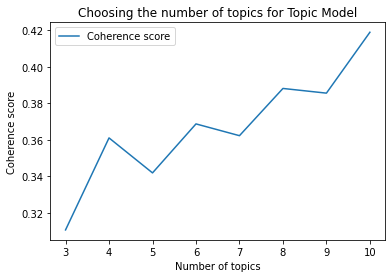

In [0]:
plt.plot(range(3,11),coherence_scores,label='Coherence score')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Choosing the number of topics for Topic Model')
plt.legend()
plt.show()

We choose to work with an LDA Topic model with 7 topics (the number is not so high and we still have good coherence score). A bigger number of topics will give too many new variables and be counterproductive. We are going to see if the word distribution per topic looks sensible.

In [0]:
lda_model = gensim.models.ldamulticore.LdaMulticore(
                             corpus=train_corpus,
                             num_topics=7,
                             id2word=train_id2word,
                             chunksize=100,
                             passes=50,
                             random_state = 20,
                             per_word_topics=True)

In [0]:
#We compute the coherence of the lda model
coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_train, dictionary=train_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.3667529248893195

In [0]:
#We represent the best LDA Topic model
lda_display = pyLDAvis.gensim.prepare(lda_model, train_corpus, train_id2word)
pyLDAvis.display(lda_display)

The word distribution in this 7 topics looks coherent.

We then create new variables equal to 1 if the probability to belong to a topic is > 0.2, 0 otherwise. 


In [0]:
#We create new variables with 1 if the probabilities to belong to each topic is > 0.2, 0 otherwise
zero_data = np.zeros(shape=(len(df_NLP),1))
df_NLP['topic_1'] = pd.DataFrame(zero_data, columns=['topic_1'])
df_NLP['topic_2'] = pd.DataFrame(zero_data, columns=['topic_2'])
df_NLP['topic_3'] = pd.DataFrame(zero_data, columns=['topic_3'])
df_NLP['topic_4'] = pd.DataFrame(zero_data, columns=['topic_4'])
df_NLP['topic_5'] = pd.DataFrame(zero_data, columns=['topic_5'])
df_NLP['topic_6'] = pd.DataFrame(zero_data, columns=['topic_6'])
df_NLP['topic_7'] = pd.DataFrame(zero_data, columns=['topic_7'])

for i in range(len(df_NLP)):
    top_topics = lda_model.get_document_topics(train_corpus[i], minimum_probability=0.0)
    if top_topics[0][1] > 0.2 : 
      df_NLP['topic_1'][i] = 1
    if top_topics[1][1] > 0.2 : 
      df_NLP['topic_2'][i] = 1
    if top_topics[2][1] > 0.2 : 
      df_NLP['topic_3'][i] = 1
    if top_topics[3][1] > 0.2 : 
      df_NLP['topic_4'][i] = 1
    if top_topics[4][1] > 0.2 : 
      df_NLP['topic_5'][i] = 1
    if top_topics[5][1] > 0.2 : 
      df_NLP['topic_6'][i] = 1
    if top_topics[6][1] > 0.2 : 
      df_NLP['topic_7'][i] = 1


And we finally get the dataset with our NLP-created variables we are going to use for our predictions :

In [0]:
#We don't need the overview and the id anymore
df_NLP= df_NLP.drop(['overview','id'], axis=1)

#We get the final base we can use to predict the variable 'vote_average'
df_NLP.head()

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,polarity,nb_review,en,fr,year,january,february,march,april,may,june,july,august,september,october,november,december,Drama,Romance,Science Fiction,Horror,Action,Comedy,Adventure,War,Crime,Thriller,Animation,Mystery,Fantasy,History,Family,Music,Western,Documentary,TV Movie,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,1,0,0,10.142662,0.0,101.0,7.3,163.0,0.674419,43,0,1,1967,0,0,0,0,1,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,1,35000000,13.492845,113374103.0,108.0,5.5,457.0,0.867987,303,1,0,1995,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0,25000000,5.146352,0.0,100.0,5.9,112.0,1.000000,4,1,0,1994,0,0,0,0,0,0,0,0,0,0,0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0,30000000,12.199047,160638883.0,133.0,7.2,636.0,0.714286,14,1,0,1994,0,0,0,0,0,0,0,0,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1,1,0,4.025276,2201126.0,99.0,7.6,106.0,0.750000,16,1,0,1994,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### **IV - Prediction models without NLP**

We first create models to predict movie ratings using only common information present in the movie_database : duration, budget,genres...

####**Metrics for evalutation and data split train/test**

In [0]:
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler

Creation of the bases X (explanatory variables) and Y (variable to predict).

In [0]:
#We keep only movies with more than 3 reviews : one film is dropped
df=df_NLP[df_NLP.nb_review>3]

s = 'Movies database has {:,} rows and {:,} columns'
print(s.format(df.shape[0], df.shape[1]))
df.head(5)

Movies database has 599 rows and 51 columns


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,polarity,nb_review,en,fr,year,january,february,march,april,may,june,july,august,september,october,november,december,Drama,Romance,Science Fiction,Horror,Action,Comedy,Adventure,War,Crime,Thriller,Animation,Mystery,Fantasy,History,Family,Music,Western,Documentary,TV Movie,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,1,0,0,10.142662,0.0,101.0,7.3,163.0,0.674419,43,0,1,1967,0,0,0,0,1,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,1,35000000,13.492845,113374103.0,108.0,5.5,457.0,0.867987,303,1,0,1995,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0,25000000,5.146352,0.0,100.0,5.9,112.0,1.000000,4,1,0,1994,0,0,0,0,0,0,0,0,0,0,0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0,30000000,12.199047,160638883.0,133.0,7.2,636.0,0.714286,14,1,0,1994,0,0,0,0,0,0,0,0,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1,1,0,4.025276,2201126.0,99.0,7.6,106.0,0.750000,16,1,0,1994,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [0]:
train_set,test_set= train_test_split(df,test_size=0.2, random_state=42)

In [0]:
#We want to predict without the new NLP-created variables, so we first drop them
suppr=['vote_average','topic_1','topic_2','topic_3','topic_4','topic_5','topic_6','topic_7','polarity','nb_review']
Y_train,Y_test= train_set['vote_average'],test_set['vote_average']
X_train, X_test= train_set.drop(suppr,axis=1),test_set.drop(suppr,axis=1)
list_variables_X = list(X_train.columns.values)

In [0]:
#Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_train = pd.DataFrame(X_train, columns=list_variables_X)
X_test = pd.DataFrame(X_test, columns=list_variables_X)

In [0]:
X_train.head()

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_count,en,fr,year,january,february,march,april,may,june,july,august,september,october,november,december,Drama,Romance,Science Fiction,Horror,Action,Comedy,Adventure,War,Crime,Thriller,Animation,Mystery,Fantasy,History,Family,Music,Western,Documentary,TV Movie
0,0.0,0.0,0.038760,0.053926,0.025786,0.304348,0.001373,1.0,0.0,0.833333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.036047,0.104794,0.000000,0.282609,0.004806,1.0,0.0,0.635417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.161541,0.121697,0.183605,0.355072,0.083562,0.0,0.0,0.916667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.038760,0.094064,0.000000,0.282609,0.011965,1.0,0.0,0.968750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.232558,0.315298,0.474398,0.282609,0.400353,1.0,0.0,0.843750,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


We create a function to evaluate the models. 

- For the regressions (r=True), we are going to compute the R^2, the MAE (Mean Absolute Error) and the MSE (Mean Squared Eror). 
- For the other models just the MAE and the MSE because R^2 is difficult to interpret. 

To esnure we have predictions between 0 and 10, we truncate the values that are below 0 and above 10. 

In [0]:
def evaluation(Y_test,Y_pred, r=True):
  Y_pred[ Y_pred < 0]=0
  Y_pred[ Y_pred > 10]=10
  if r:
    print('R^2 : ', r2_score(Y_test, Y_pred))
  mae = metrics.mean_absolute_error(Y_test, Y_pred)
  mse = metrics.mean_squared_error(Y_test, Y_pred)
  print('Mean Absolute Error :', mae)  
  print('Mean Squared Error :', mse)
  return(mae,mse)


We are going to use different models with our databases.

To compare the distribution of the prediction with the true results, we first plot Y_test. 

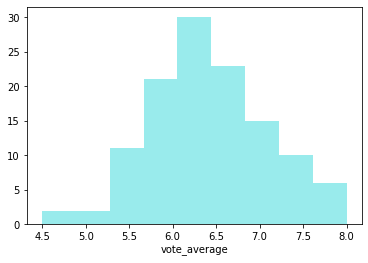

In [0]:
sns.distplot(Y_test, kde=False, color='darkturquoise')

####**A naive estimator : the mean**

We first compute a naive estimator equal to the mean of the ratings. This is the simplest model. 

In [0]:
Y_pred=pd.DataFrame([Y_test.mean()]*len(Y_test))
mae_naive, mse_naive=evaluation(Y_test,Y_pred,r=False)

Mean Absolute Error : 0.5475833333333332
Mean Squared Error : 0.4827493055555555


####**Linear Regression**

R^2 :  0.307351194109157
Mean Absolute Error : 0.45547037760416664
Mean Squared Error : 0.3343757300376893


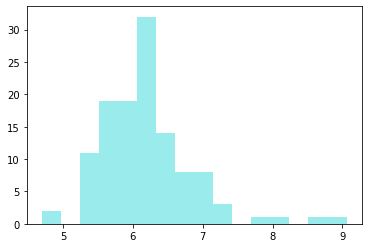

In [0]:
#Linear Regression
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train,Y_train)
Y_pred_reg= regr.predict(X_test)

mae_regr, mse_regr = evaluation(Y_test,Y_pred_reg)

sns.distplot(Y_pred_reg, kde=False, color='darkturquoise')

####**Random Forest**

We now try a Random Forest model

Mean Absolute Error : 0.44198858464312535
Mean Squared Error : 0.2837818781388686


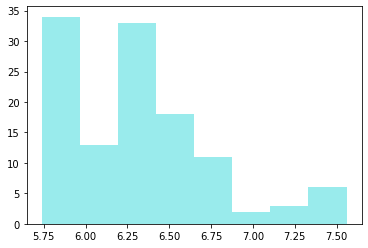

In [0]:
#Random Forest 
from sklearn.ensemble import RandomForestRegressor 

rf=RandomForestRegressor(random_state=0, max_features='auto', n_estimators= 50, max_depth=5)

rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

mae_rf, mse_rf = evaluation(Y_test,Y_pred, r=False)

sns.distplot(Y_pred, kde=False, color='darkturquoise')

We can see that the predictions with the Random Forest are less extensive than the real values of Y_test and the predictions obtained using the Linear Regression.

In [0]:
#We use GridSearchCV to choose the best parameters
#We choose the maximum of n_estimators to test at 500 because it is too long otherwise

param_grid = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(5, 16)
}

CV_regressor = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_regressor.fit(X_train, Y_train)

best_params = CV_regressor.best_params_
best_params

{'max_depth': 13, 'max_features': 'auto', 'n_estimators': 500}

Mean Absolute Error : 0.4360106651848719
Mean Squared Error : 0.3072457557058111


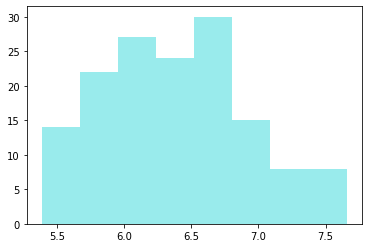

In [0]:
#Random Forest with best parameters

rf=RandomForestRegressor(random_state=0, max_features = best_params['max_features'], n_estimators= best_params['n_estimators'], max_depth=best_params['max_depth'])

rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

mae_rf, mse_rf = evaluation(Y_test,Y_pred, r=False)

sns.distplot(Y_pred, kde=False, color='darkturquoise')

In [0]:
#Variables importance : we only show the 15 most important variables

rf.fit(X_train, Y_train)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Ranking of the importance of parameters:")

for f in range(15):
    i=indices[f]
    print("%d. parameters %d : " % (f + 1, i) + X_train.columns[i] + " (%f)" % (importances[i]))

Ranking of the importance of parameters:
1. parameters 9 : year (0.170772)
2. parameters 6 : vote_count (0.164992)
3. parameters 5 : runtime (0.146353)
4. parameters 2 : budget (0.104822)
5. parameters 22 : Drama (0.092219)
6. parameters 3 : popularity (0.076366)
7. parameters 4 : revenue (0.049344)
8. parameters 39 : Documentary (0.027613)
9. parameters 34 : Animation (0.022902)
10. parameters 7 : en (0.015814)
11. parameters 31 : Thriller (0.009999)
12. parameters 26 : Action (0.009879)
13. parameters 27 : Comedy (0.007770)
14. parameters 25 : Horror (0.006509)
15. parameters 16 : july (0.006301)


The most important variable is the variable 'year' : there exists perhaps a kind of trend in the note (older movies get better notes for example). 

We can see that the most important variables to explain the 'vote_average' are quite logic : the 'vote_count', 'runtime', 'popularity' and 'budget' are quite important as some genres such as 'Documentary', 'Horror', 'Drama'. 

####**XGBoost**

We finally use XGBoost. 

In [0]:
#XGBoost
import xgboost as xgb
#Grid search to find the best estimator
estimator = xgb.XGBRegressor(objective= 'reg:squarederror')

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05,0.001]
}
grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,scoring = 'neg_mean_squared_error',n_jobs = 10,cv = 5,)

grid_search.fit(X_train, Y_train)

R^2 :  0.4616589111344963
Mean Absolute Error : 0.39660494248072303
Mean Squared Error : 0.25988378680184354


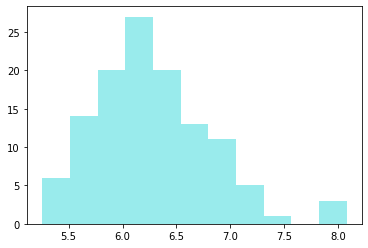

In [0]:
best_estimator = grid_search.best_estimator_
Y_pred=best_estimator.predict(X_test)
mae_xgb, mse_xgb =evaluation(Y_test,Y_pred, r=True)

sns.distplot(Y_pred, kde=False, color='darkturquoise')

XGBoost clearly outperforms the other models (regarding both the MAE and the MSE). 

### **V - Prediction models using NLP**

We then are going to add our NLP-created variables to see if it improves our predictions. We have 9 new variables : 7 topic model variables, a sentiment variable and a number of review. 

In [0]:
Y_train,Y_test= train_set['vote_average'],test_set['vote_average']
X_train, X_test= train_set.drop(['vote_average'],axis=1),test_set.drop(['vote_average'],axis=1)
list_variables_X = list(X_train.columns.values)

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_train = pd.DataFrame(X_train, columns=list_variables_X)
X_test = pd.DataFrame(X_test, columns=list_variables_X)

In [0]:
X_train.head()

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_count,polarity,nb_review,en,fr,year,january,february,march,april,may,june,july,august,september,october,november,december,Drama,Romance,Science Fiction,Horror,Action,Comedy,Adventure,War,Crime,Thriller,Animation,Mystery,Fantasy,History,Family,Music,Western,Documentary,TV Movie,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,0.0,0.0,0.038760,0.053926,0.025786,0.304348,0.001373,0.809756,0.051587,1.0,0.0,0.833333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.036047,0.104794,0.000000,0.282609,0.004806,0.700000,0.002646,1.0,0.0,0.635417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.161541,0.121697,0.183605,0.355072,0.083562,1.000000,0.000661,0.0,0.0,0.916667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.038760,0.094064,0.000000,0.282609,0.011965,0.600000,0.007275,1.0,0.0,0.968750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.232558,0.315298,0.474398,0.282609,0.400353,0.876923,0.048942,1.0,0.0,0.843750,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


####**Linear Regression**

R^2 :  0.30854550193067687
Mean Absolute Error : 0.4556134060946403
Mean Squared Error : 0.333799178766231


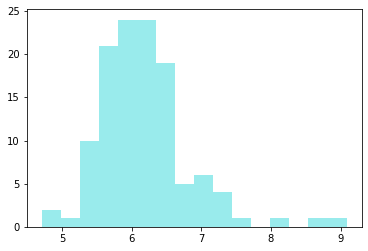

In [0]:
#Linear Regression
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train,Y_train)
Y_pred= regr.predict(X_test)

mae_regr_NLP, mse_regr_NLP = evaluation(Y_test,Y_pred)

sns.distplot(Y_pred, kde=False, color='darkturquoise')

####**Random Forest**

Mean Absolute Error : 0.4528932322420716
Mean Squared Error : 0.30265463083512273


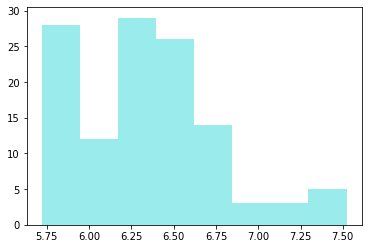

In [0]:
#Random Forest 
from sklearn.ensemble import RandomForestRegressor 

rf=RandomForestRegressor(random_state=0, max_features='auto', n_estimators= 50, max_depth=5)

rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

mae_rf_NLP, mse_rf_NLP = evaluation(Y_test,Y_pred, r=False)

sns.distplot(Y_pred, kde=False, color='darkturquoise')

In [0]:
#We use GridSearchCV to choose the best parameters
#We choose the maximum of n_estimators to test at 500 because it is too long otherwise

param_grid = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(5, 16)
}

CV_regressor = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_regressor.fit(X_train, Y_train)

best_params = CV_regressor.best_params_
best_params

{'max_depth': 18, 'max_features': 'auto', 'n_estimators': 500}

Mean Absolute Error : 0.4381433512846971
Mean Squared Error : 0.31032204164321914


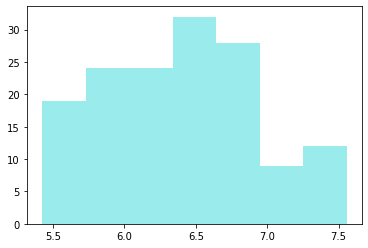

In [0]:
rf=RandomForestRegressor(random_state=0, max_features = best_params['max_features'], n_estimators= best_params['n_estimators'], max_depth=best_params['max_depth'])

rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

mae_rf_NLP, mse_rf_NLP = evaluation(Y_test,Y_pred, r=False)

sns.distplot(Y_pred, kde=False, color='darkturquoise')

In [0]:
#Variables importance : we only show the 15 most important variables

rf.fit(X_train, Y_train)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Ranking of the importance of parameters:")

for f in range(15):
    i=indices[f]
    print("%d. parameter %d : " % (f + 1, i) + X_train.columns[i] + " (%f)" % (importances[i]))

Ranking of the importance of parameters:
1. parameter 11 : year (0.155683)
2. parameter 6 : vote_count (0.141762)
3. parameter 5 : runtime (0.130067)
4. parameter 2 : budget (0.091630)
5. parameter 24 : Drama (0.090129)
6. parameter 3 : popularity (0.062303)
7. parameter 8 : nb_review (0.056853)
8. parameter 4 : revenue (0.040573)
9. parameter 7 : polarity (0.033786)
10. parameter 41 : Documentary (0.026565)
11. parameter 36 : Animation (0.021921)
12. parameter 9 : en (0.013926)
13. parameter 33 : Thriller (0.008830)
14. parameter 28 : Action (0.008624)
15. parameter 48 : topic_6 (0.006762)


We can see that the Topic Model varaibles are not the most important. 

####**XGBoost**

In [0]:
#XGBoost
#Grid search to find the best estimator
estimator = xgb.XGBRegressor(objective= 'reg:squarederror',seed=42)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,scoring = 'neg_mean_squared_error',n_jobs = 10,cv = 5,)

grid_search.fit(X_train, Y_train)

R^2 :  0.49041184432311036
Mean Absolute Error : 0.3802893416086833
Mean Squared Error : 0.24600332827235485


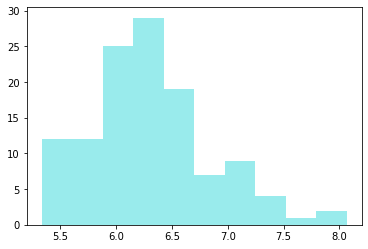

In [0]:
best_estimator = grid_search.best_estimator_
Y_pred=best_estimator.predict(X_test)
mae_xgb_NLP, mse_xgb_NLP=evaluation(Y_test,Y_pred, r=True)

sns.distplot(Y_pred, kde=False, color='darkturquoise')

Here too, XGBoost is clearly the best model. 

### **VI - Comparison of the models and conclusion**

####**Comparison of the models**

We compare the models using the Mean Absolute Error (MAE) and the Mean Squared Error (MSE), for each model, and using or not the variables created using the NLP tools (Sentiment Analysis and Topic Model).

In [0]:
MAE=[mae_naive,mae_regr,mae_rf,mae_xgb]
MSE=[mse_naive, mse_regr,mse_rf,mse_xgb]
MAE_NLP=[mae_naive,mae_regr_NLP,mae_rf_NLP,mae_xgb_NLP]
MSE_NLP=[mse_naive,mse_regr_NLP,mse_rf_NLP,mse_xgb_NLP]

col={'Mean Absolute Error':MAE,'Mean Squared Error':MSE, 'Mean Absolute Error NLP':MAE_NLP,'Mean Squared Error NLP':MSE_NLP }
models=['Naive Estimator', 'Linear Regression', 'Random Forest', 'XGBoost']
df_compare=pd.DataFrame(data=col,index=models)
df_compare

,Mean Absolute Error,Mean Squared Error,Mean Absolute Error NLP,Mean Squared Error NLP
Naive Estimator,0.547583,0.482749,0.547583,0.482749
Linear Regression,0.455470,0.334376,0.455613,0.333799
Random Forest,0.441989,0.283782,0.452893,0.302655
XGBoost,0.396605,0.259884,0.380289,0.246003


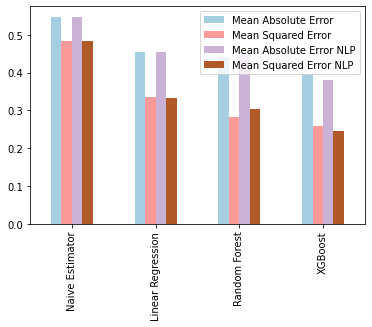

In [0]:
df_compare.plot(kind='bar', colormap='Paired')

####**Conclusion**

We can see that the model that gives the lowest Mean Absolute Error is the XGBoost model using the variables created using NLP tools. However the difference with the XGBoost using only usual variables is quite small (improvement of 0.014 in the MSE) and we don't think it is a significant improvement. When we rank the parameters by importance for the Random Forest model, we can see that the NLP variables are not so important. 

To conlude, we were able to implement a sentiment classifier with an average accuracy of 92%. However, the use of NLP in our project don't allow us to improve significantly our predictions. 

Several problems could explain why the predictive power of our NLP-created variables is low. The sample of Amazon reviews might not be representative of the entire reviews. Another problem might be we've trained our classifier with IDMB review but Amazon review contains not just comment about the movie but also sometimes information on the time delivery : this might noise our predictions.  

We believe our variables remains however interesting if we could have more data or it can be useful for example to predict TV consumption of television viewers if we know the programs they use to see but not the genres of these programs.